# Internal reference scaling pipeline
### Used to normalize protein quantities across two TMT 10-plexes
### Derived from https://github.com/pwilmart/IRS_normalization. See Philip Wilmart's Jupyter Notebook for a detailed description of the methods used here 

### Import required libraries

In [1]:
# Analysis of TMT data with 2 10plexes

# load libraries (this gets ggplot2 and related libraries)
library(tidyverse)

# these are from Bioconductor
library(limma) 
library(edgeR) 
library(sva)

# we use this for the pairwise correlation plots
library(psych)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: mgcv
Loading required package: nlme

Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Loading required package: genefilter

Attaching package: 'genefilter'

The following object is masked from 'package:readr':

    spec

Loading required package: BiocParallel

Attaching package: 'psych'

The following object is masked from 'package:genefilter':

    AUC

The following objects are masked from 'package:ggplot2':

    %+%, alpha



#### Import TMT intensities and store annotations

In [2]:
# read the TMT data in as a .csv
data_start <- read_csv('../Intermediate data/Filtered_PAW_protein_intensities.csv')

# filter out proteins not seen in all three runs
data_no_na <- na.omit(data_start)

# save the annotations (gene symbol and protein accession) and remove from data frame
annotate_df <- data_no_na[1:2] 
data_raw <- as.data.frame(data_no_na[3:22]) 
row.names(data_raw) <- annotate_df$`Accession`


Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


#### Visualize the data prior to normalization

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 1 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 2 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 3 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 4 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 5 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 6 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 7 is not drawn"Warning message in bplt(at[i], wid = width[i], s

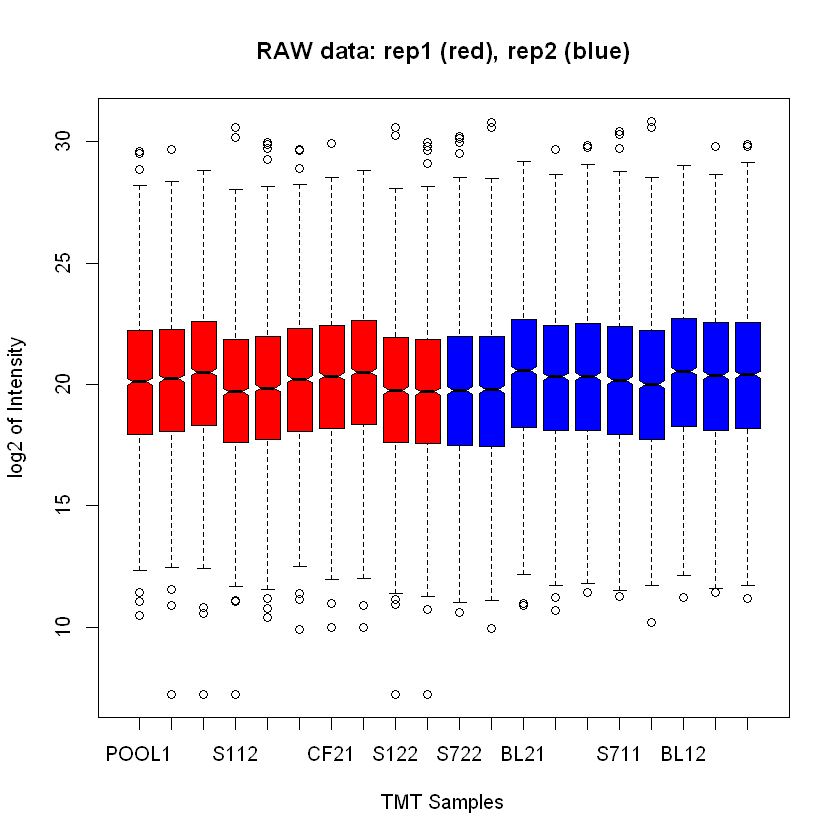

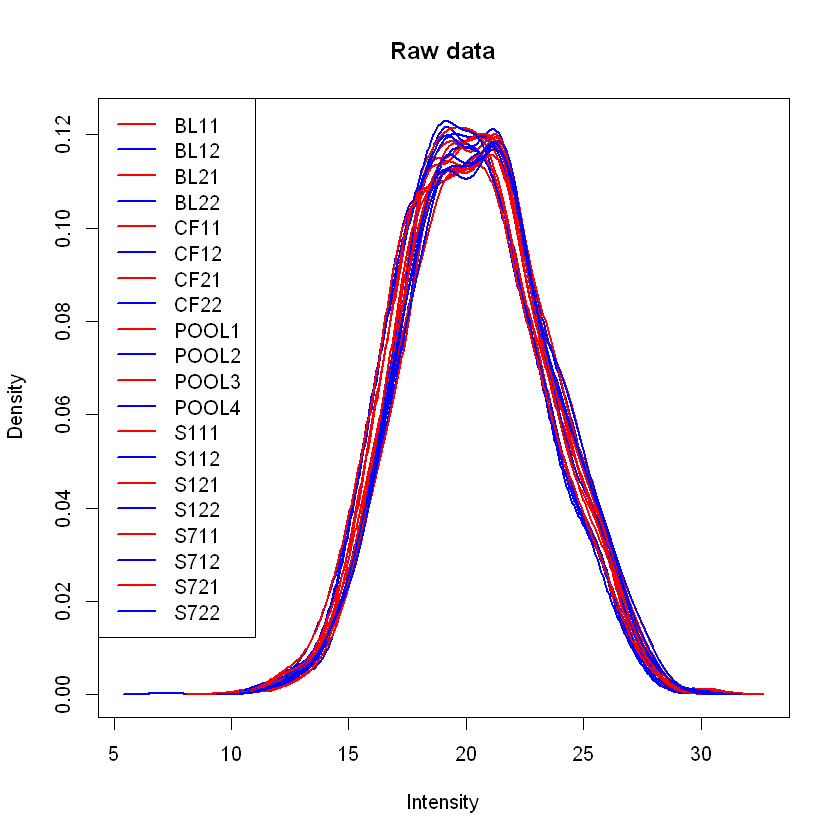

In [3]:
# Unnormalized data visualization
boxplot(log2(data_raw), col = rep(c('red', 'blue'), each = 10), 
        notch = TRUE, main = 'RAW data: rep1 (red), rep2 (blue)',
        xlab = 'TMT Samples', ylab = 'log2 of Intensity')

plotDensities(log2(data_raw), col = rep(c('red', 'blue'), 10), 
              main = 'Raw data')


In [4]:
# check the column totals (per channel sums)
format(round(colSums(data_raw), digits = 0), big.mark = ",")

POOL1             CF11             BL22             S112 
"19,977,301,535" "19,262,422,846" "22,380,438,719" "17,316,754,978" 
            S721            POOL2             CF21             BL11 
"18,873,021,626" "20,863,946,948" "21,105,128,766" "23,231,914,670" 
            S122             S712             S722             S111 
"18,285,476,631" "17,130,287,008" "20,511,298,505" "19,898,729,409" 
            BL21             CF12            POOL3             S711 
"25,553,256,036" "21,925,236,855" "24,057,361,734" "26,122,451,672" 
            S121             BL12             CF22            POOL4 
"22,394,715,910" "25,534,933,918" "23,168,656,910" "24,922,741,359"

### Apply Sample Loading (SL) Normalization

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 1 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 2 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 3 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 4 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 5 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 6 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 7 is not drawn"Warning message in bplt(at[i], wid = width[i], s

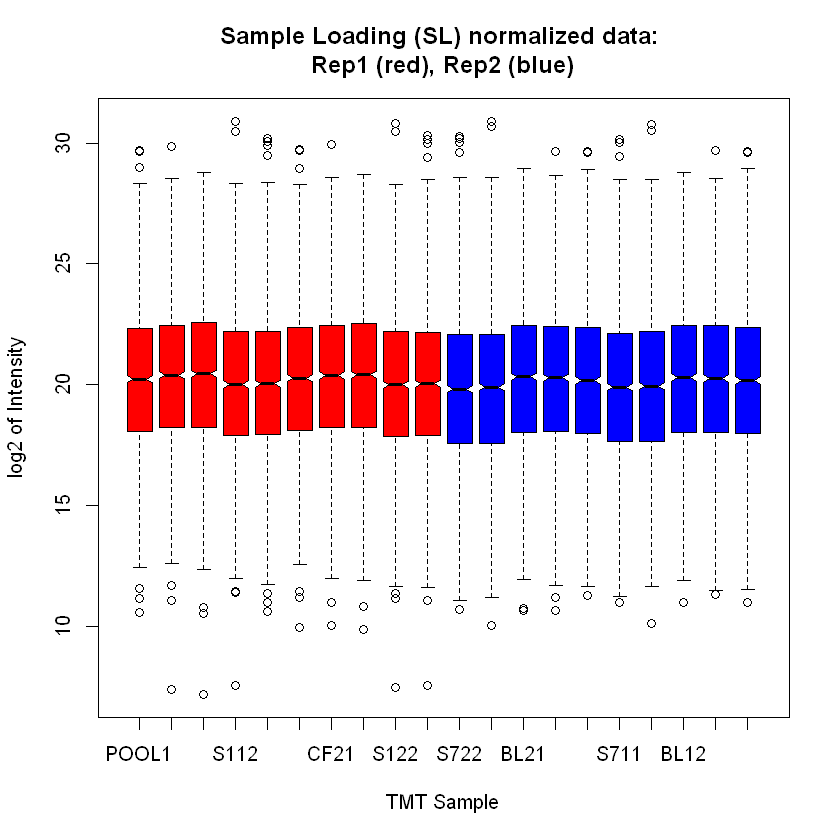

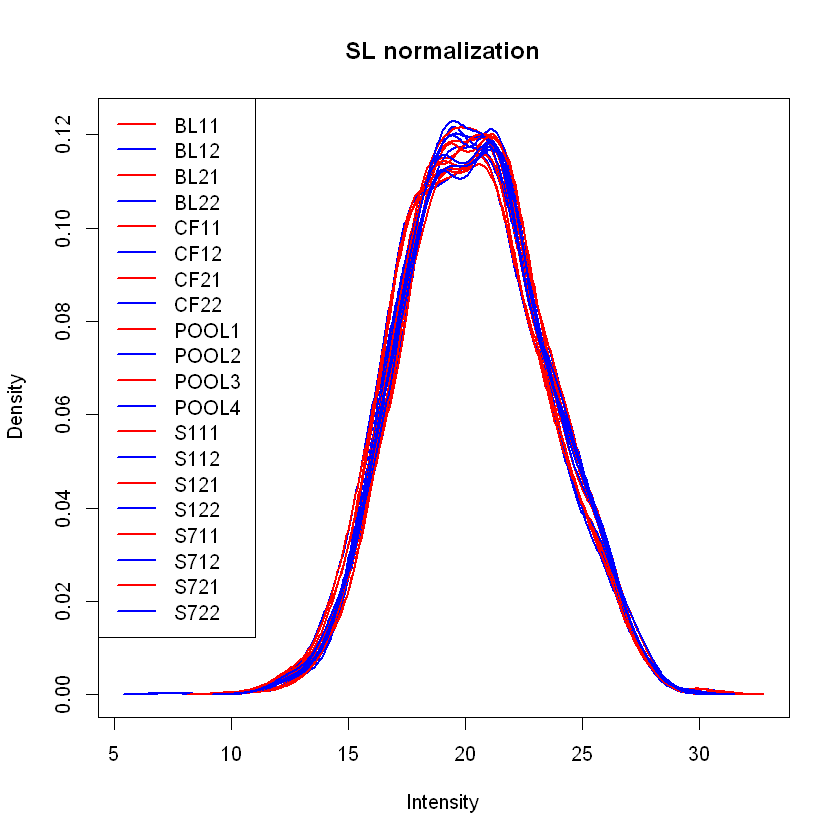

In [5]:
# separate the TMT data by TMT-10plex
rep1_raw <- data_raw[c(1:10)]
rep2_raw <- data_raw[c(11:20)]

# first basic normalization is to adjust each TMT experiment to equal signal per channel
# figure out the global scaling value
target <- mean(c(colSums(rep1_raw), colSums(rep2_raw)))

# do the sample loading normalization before the IRS normalization
# there is a different correction factor for each column
norm_facs <- target / colSums(rep1_raw)
rep1_sl <- sweep(rep1_raw, 2, norm_facs, FUN = "*")
norm_facs <- target / colSums(rep2_raw)
rep2_sl <- sweep(rep2_raw, 2, norm_facs, FUN = "*")

# make a pre-IRS data frame after sample loading normalizations
data_sl <- cbind(rep1_sl, rep2_sl)

# see what the SL normalized data look like
boxplot(log2(data_sl), col = rep(c("red", "blue"), each = 10), 
        notch = TRUE, main = "Sample Loading (SL) normalized data: \nRep1 (red), Rep2 (blue)",
        xlab = 'TMT Sample', ylab = 'log2 of Intensity')

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_sl), col = rep(c("red", "blue"), 10), main = "SL normalization")


In [6]:
# check the columnn totals
format(round(colSums(data_sl), digits = 0), big.mark = ",")

POOL1             CF11             BL22             S112 
"21,625,803,802" "21,625,803,802" "21,625,803,802" "21,625,803,802" 
            S721            POOL2             CF21             BL11 
"21,625,803,802" "21,625,803,802" "21,625,803,802" "21,625,803,802" 
            S122             S712             S722             S111 
"21,625,803,802" "21,625,803,802" "21,625,803,802" "21,625,803,802" 
            BL21             CF12            POOL3             S711 
"21,625,803,802" "21,625,803,802" "21,625,803,802" "21,625,803,802" 
            S121             BL12             CF22            POOL4 
"21,625,803,802" "21,625,803,802" "21,625,803,802" "21,625,803,802"

### Apply trimmed mean of M values (TMM) normalization

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 1 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 2 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 3 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 4 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 5 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 6 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 7 is not drawn"Warning message in bplt(at[i], wid = width[i], s

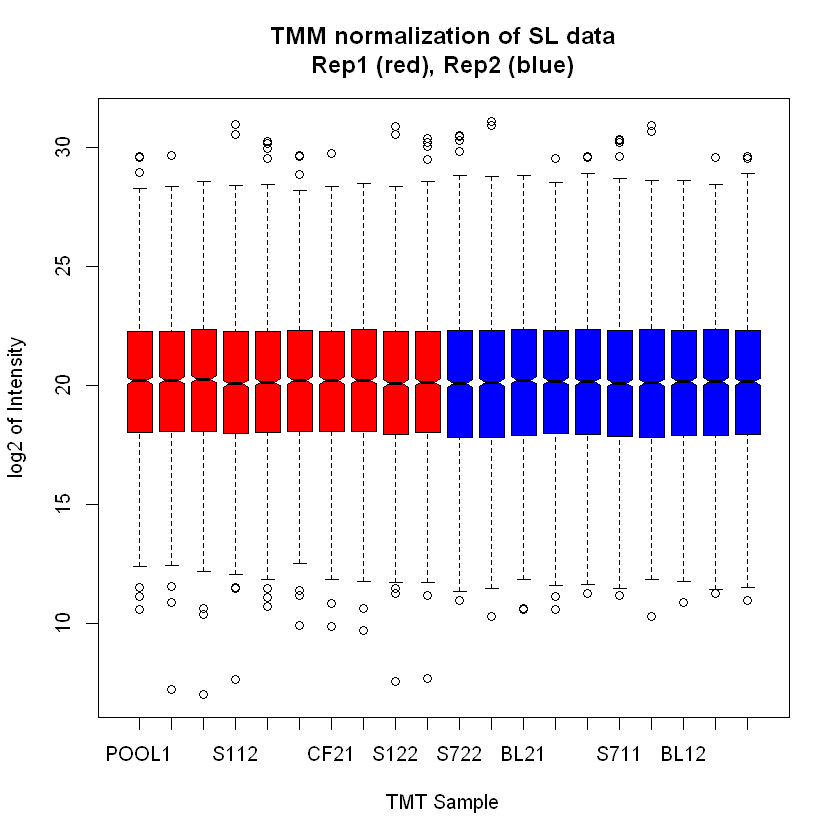

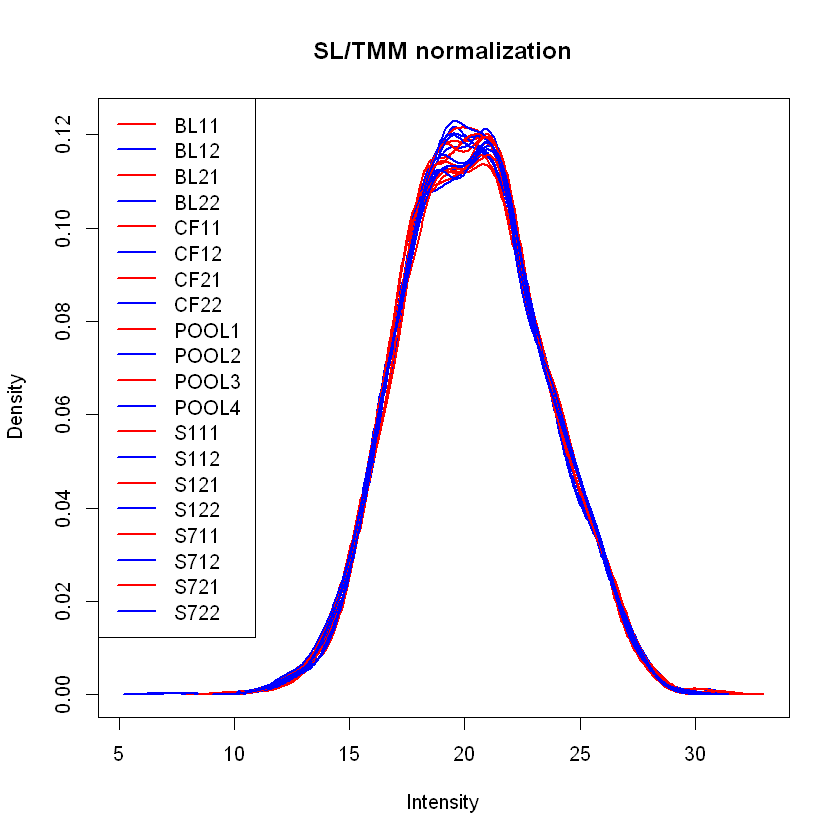

In [7]:
# do TMM on raw data - we use it later for CV analyses
raw_tmm <- calcNormFactors(data_raw)
data_raw_tmm <- sweep(data_raw, 2, raw_tmm, FUN = "/") # raw data after TMM on original scale

# perform TMM on the SL-normed data and visualize resulting distributions
sl_tmm <- calcNormFactors(data_sl)
data_sl_tmm <- sweep(data_sl, 2, sl_tmm, FUN = "/") # data after SL and TMM on original scale

boxplot(log2(data_sl_tmm), notch = TRUE, col = rep(c("red", "blue"), each = 10), 
        main = "TMM normalization of SL data\nRep1 (red), Rep2 (blue)",
        xlab = 'TMT Sample', ylab = 'log2 of Intensity')

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_sl_tmm), col = rep(c("red", "blue"), 10), main = "SL/TMM normalization")

In [8]:
# check column totals
format(round(colSums(data_sl_tmm), digits = 0), big.mark = ",")

POOL1             CF11             BL22             S112 
"21,135,769,114" "19,198,866,904" "19,088,701,939" "22,726,097,428" 
            S721            POOL2             CF21             BL11 
"23,062,942,188" "20,762,851,655" "19,303,623,781" "19,170,266,694" 
            S122             S712             S722             S111 
"23,089,592,340" "23,247,843,504" "26,121,946,219" "25,387,342,607" 
            BL21             CF12            POOL3             S711 
"20,168,753,605" "20,166,020,910" "21,474,290,149" "24,914,487,930" 
            S121             BL12             CF22            POOL4 
"24,359,330,835" "19,822,696,489" "20,196,645,523" "21,241,366,280"

### Clustering of the samples using SL/TMM 

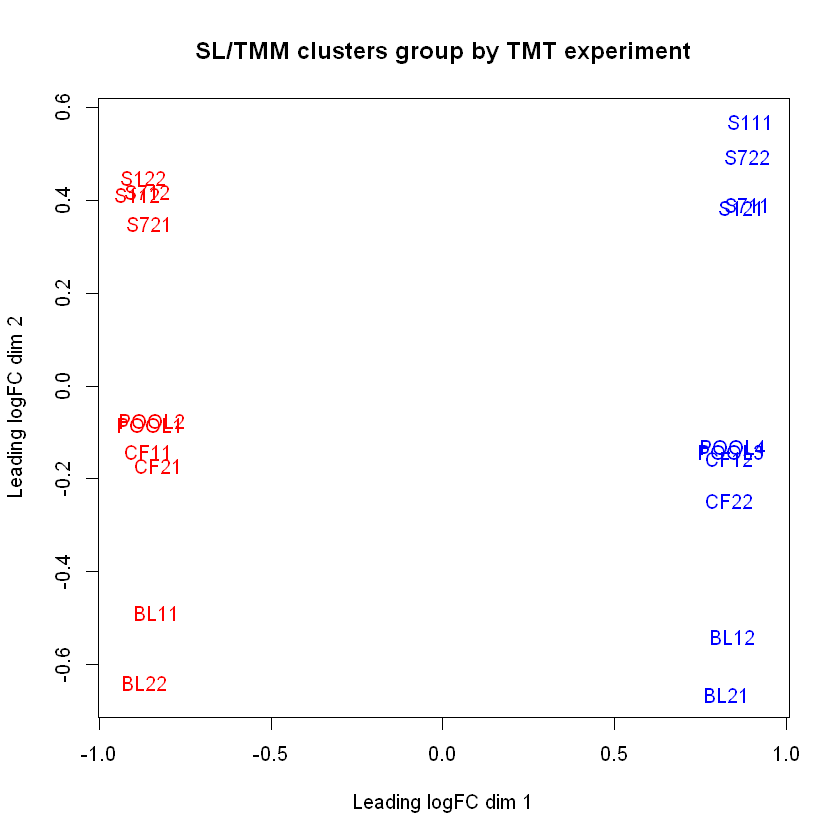

In [9]:
# see how things cluster now that we have nice boxplots and density plots
plotMDS(log2(data_sl_tmm), col = rep(c("red", "blue"), each = 10), 
        main = "SL/TMM clusters group by TMT experiment")


###### Cluserting with of the SL/TMM normalized data shows that there is separation along dimension two that shows grouping of replicates but along the x axis there is clear separation based on the TMT-10plex that the samples belonged to, shown by the difference in text color. This indicates that further normalization is required. 

### Internal Reference Scaling

Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 1 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 2 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 3 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 4 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 5 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 6 is not drawn"Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
"Outlier (-Inf) in boxplot 7 is not drawn"Warning message in bplt(at[i], wid = width[i], s

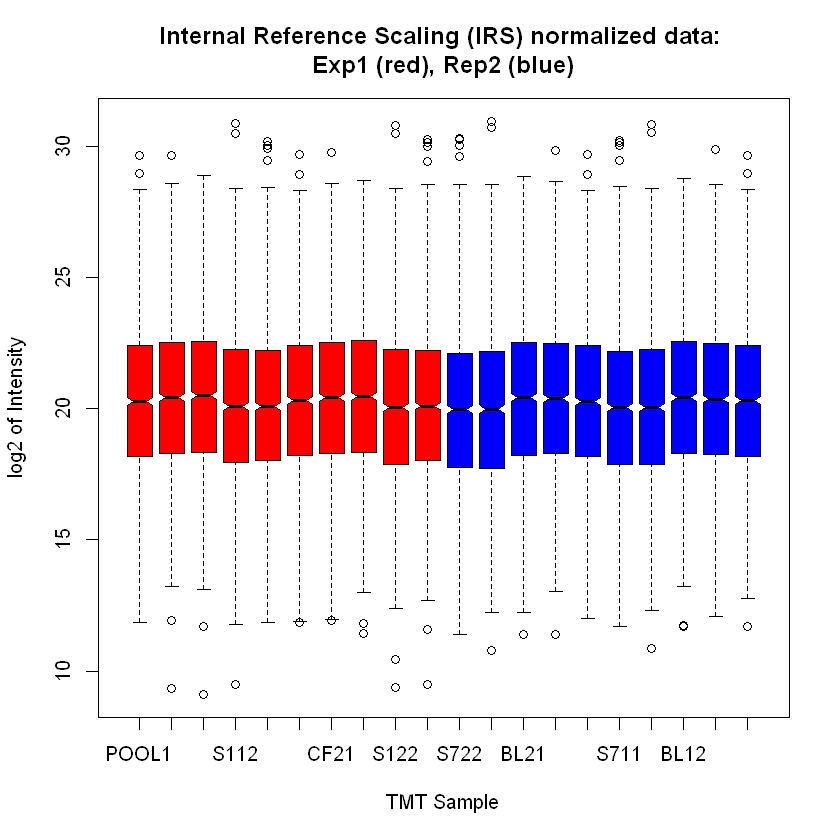

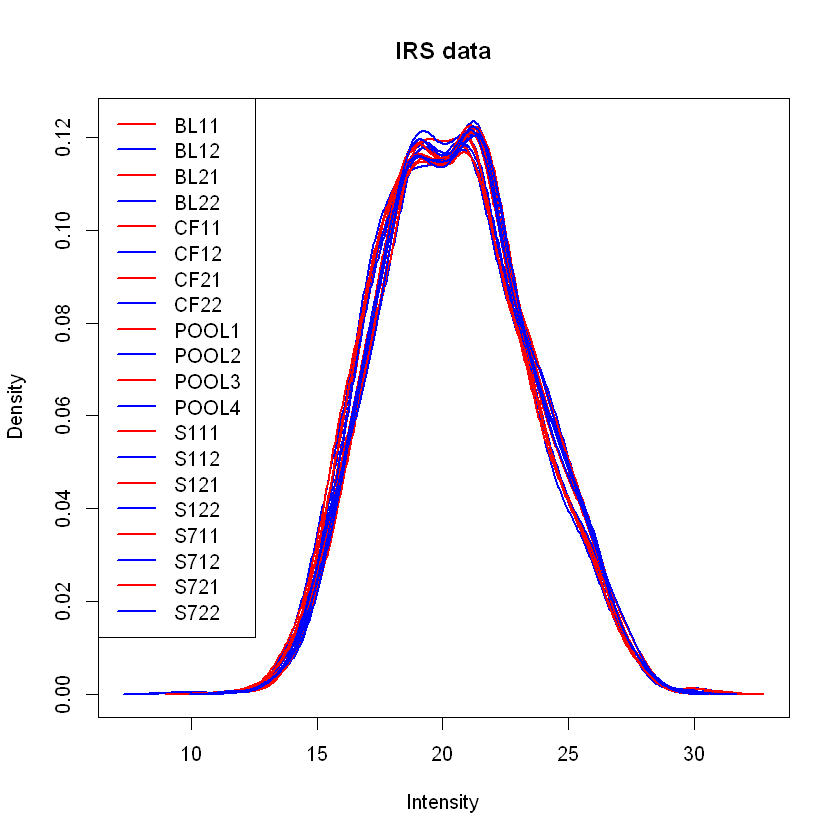

In [10]:
# make new data frame with the pooled samples
irs <- tibble(rowSums(rep1_sl %>% select(1,6)),rowSums(rep2_sl %>% select(5,10)))
colnames(irs) <- c("sum1", "sum2")

# get the geometric average intensity for each protein
irs$average <- apply(irs, 1, function(x) exp(mean(log(x))))

# compute the scaling factor vectors
irs$fac1 <- irs$average / irs$sum1
irs$fac2 <- irs$average / irs$sum2

# make new data frame with IRS normalized data
data_irs <- rep1_sl * irs$fac1
data_irs <- cbind(data_irs, rep2_sl * irs$fac2)
    
# see what the IRS data look like
boxplot(log2(data_irs), col = rep(c("red", "blue"), each = 10), 
        main = "Internal Reference Scaling (IRS) normalized data: \nExp1 (red), Rep2 (blue)",
        xlab = 'TMT Sample', ylab = 'log2 of Intensity', notch = TRUE)

# can also look at density plots (like a distribution histogram)    
plotDensities(log2(data_irs), col = rep(c("red", "blue"), 10), main = "IRS data")

In [11]:
# check column totals and eliminate any columns with NaN
data_irs <- na.omit(data_irs)
format(round(colSums(data_irs), digits = 0), big.mark = ",")

POOL1             CF11             BL22             S112 
"21,500,927,787" "21,440,062,762" "21,620,064,154" "21,476,464,867" 
            S721            POOL2             CF21             BL11 
"21,479,226,354" "21,505,225,427" "21,446,123,137" "21,573,363,046" 
            S122             S712             S722             S111 
"21,474,968,597" "21,492,821,236" "21,547,092,129" "21,562,166,635" 
            BL21             CF12            POOL3             S711 
"21,383,845,174" "21,564,187,506" "21,502,079,425" "21,539,590,376" 
            S121             BL12             CF22            POOL4 
"21,552,044,744" "21,411,573,484" "21,555,525,772" "21,504,073,788"

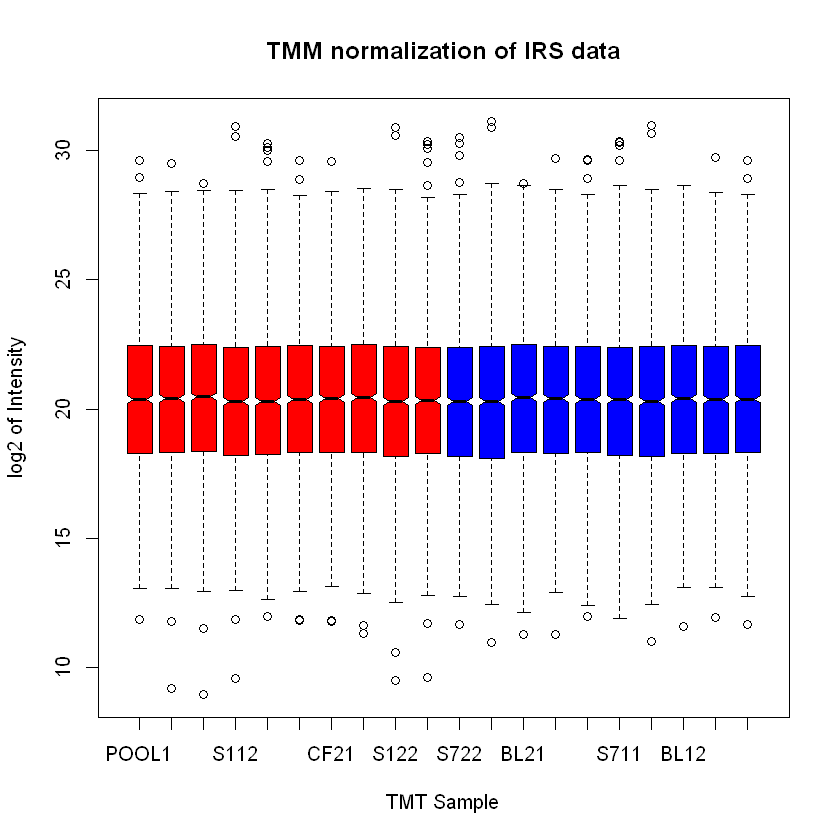

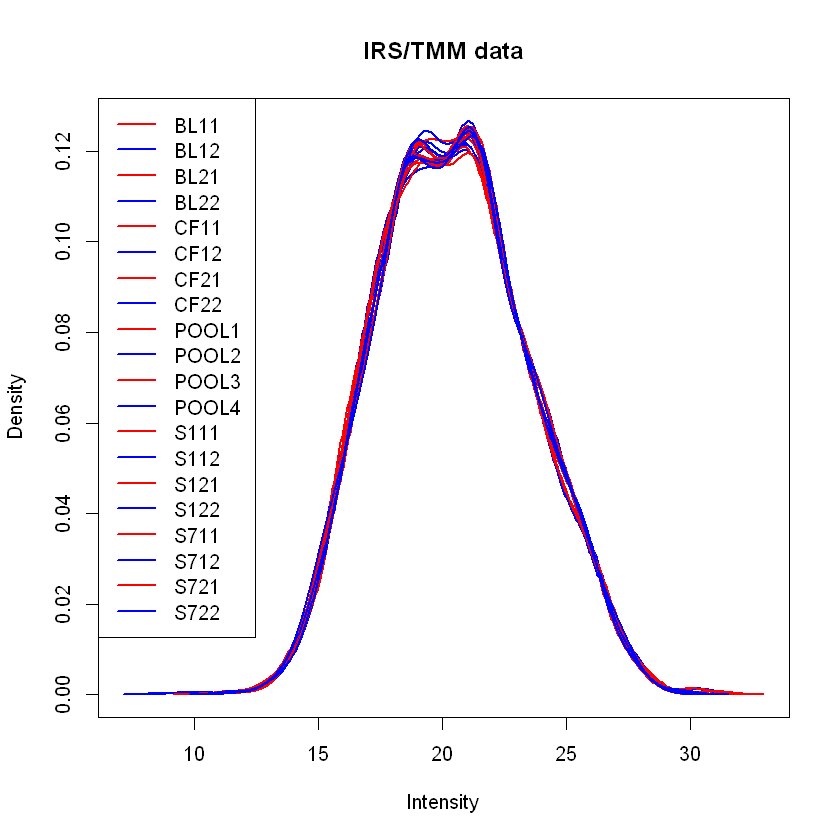

In [12]:
# this is data after SL, IRS, and TMM normalized on original scale
irs_tmm <- calcNormFactors(data_irs)
data_irs_tmm <- sweep(data_irs, 2, irs_tmm, FUN = "/") 

# see if box plots are aligned
boxplot(log2(data_irs_tmm), notch = TRUE, col = rep(c("red", "blue"), each = 10), 
        main = "TMM normalization of IRS data",
        xlab = 'TMT Sample', ylab = 'log2 of Intensity')

# can also look at density plots (like a distribution histogram)
plotDensities(log2(data_irs_tmm), col = rep(c("red", "blue"), 10), main = "IRS/TMM data")


In [13]:
# check the column totals
format(round(colSums(data_irs_tmm), digits = 0), big.mark = ",")

POOL1             CF11             BL22             S112 
"21,267,231,409" "19,362,410,253" "19,421,261,932" "22,824,215,028" 
            S721            POOL2             CF21             BL11 
"23,169,563,209" "20,925,281,111" "19,397,956,096" "19,422,723,103" 
            S122             S712             S722             S111 
"23,238,230,595" "23,390,582,709" "25,385,544,495" "24,758,241,983" 
            BL21             CF12            POOL3             S711 
"19,883,057,881" "19,849,987,082" "21,152,677,697" "24,317,199,028" 
            S121             BL12             CF22            POOL4 
"23,680,455,792" "19,615,619,133" "19,817,712,286" "21,051,127,942"

### Clustering of samples after IRS/TMM normalization

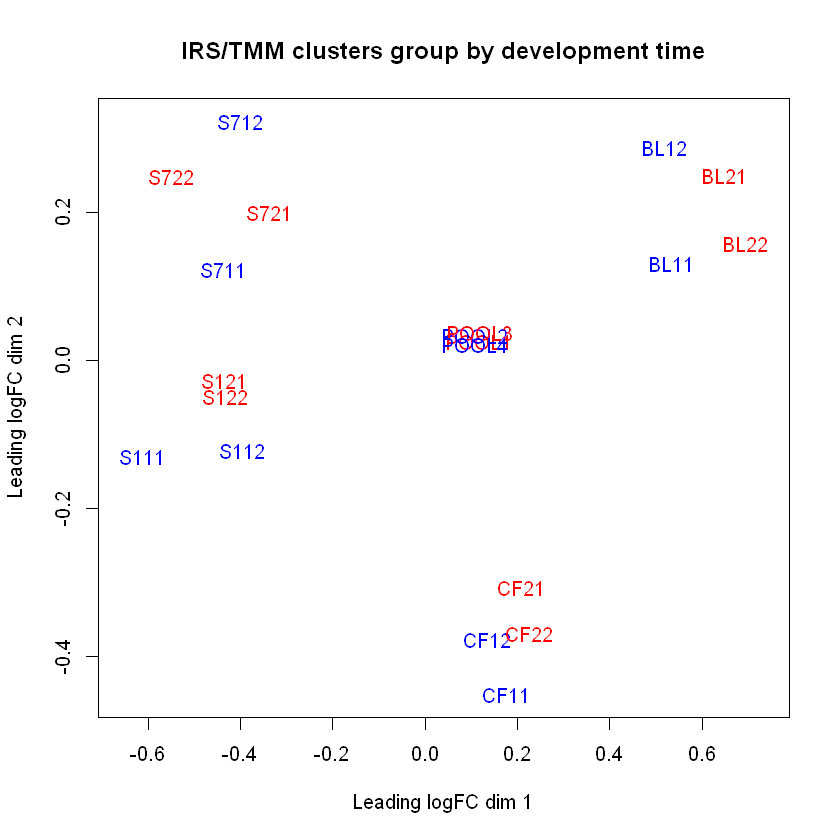

In [14]:
col_vec <- c("red", "blue")
plotMDS(log2(data_irs_tmm), col = col_vec, main = "IRS/TMM clusters group by development time")

###### Samples cluster according to their experimenatal condition as expected, regardless of which 10plex the samples came from. The similarity in density plots and clustering indicates that the normalization was successful.

### Export a csv file of the normalized data for downstream analysis

In [15]:
data_irs_sorted = data_irs[ , order(names(data_irs))]

write.csv(data_irs_sorted,file="../Intermediate data/IRS_norm_data_no_labels.csv")

###### This csv is then uploaded in the script: label_mapping.ipynb